## Moive Success (Awards and Box Office) Prediction ##


In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

### Data Cleaning ##

In [3]:
df = pd.read_csv('result.csv',index_col=['imdbID'])

df['BoxOffice'] = df['BoxOffice'].replace( '[\$,)]','', regex=True ).astype(float)
df['Runtime'] = df['Runtime'].replace( 'min','', regex=True ).astype(int)
df['Year'] = df['Year'].astype(int)
df['Released'] = [a[3:6] for a in df['Released']]
df = df[np.isfinite(df['Opening Weekend USA'])]

df[:2]

,Actors,Awards,BoxOffice,Country,DVD,Director,Genre,Language,Metascore,Production,...,Writer,Year,imdbRating,imdbVotes,Cumulative Worldwide Gross,Gross USA,Opening Weekend USA,budget,critic number,user review number
imdbID,,,,,,,,,,,,,,,,,,,,,
tt0499549,"Sam Worthington, Zoe Saldana, Sigourney Weaver...",Won 3 Oscars. Another 85 wins & 128 nominations.,749700000.0,"UK, USA",22 Apr 2010,James Cameron,"Action, Adventure, Fantasy","English, Spanish",83.0,20th Century Fox,...,James Cameron,2009,7.8,"985,058",2.787965e+09,760507625.0,77025481.0,237000000,720.0,3167.0
tt1055369,"Shia LaBeouf, Megan Fox, Josh Duhamel, Tyrese ...",Nominated for 1 Oscar. Another 15 wins & 27 no...,402076689.0,USA,20 Oct 2009,Michael Bay,"Action, Adventure, Sci-Fi","English, Spanish",35.0,Paramount/Dreamworks,...,"Ehren Kruger, Roberto Orci, Alex Kurtzman",2009,6.0,"349,263",8.363037e+08,402111870.0,108966307.0,200000000,373.0,1459.0


In [161]:
df = df.sample(frac=1).reset_index(drop=True)

print (len(df))

3025


The bins are:
label 0 : 64.99999999999999 - 812.506199988389 , 3.0 movies
label 1 : 812.506199988389 - 10156.4050003011 , 126.0 movies
label 2 : 10156.4050003011 - 126956.0312667343 , 807.0 movies
label 3 : 126956.0312667343 - 1586962.5004637125 , 434.0 movies
label 4 : 1586962.5004637125 - 19837182.62732065 , 1005.0 movies
label 5 : 19837182.62732065 - 247966674.99999967 , 650.0 movies


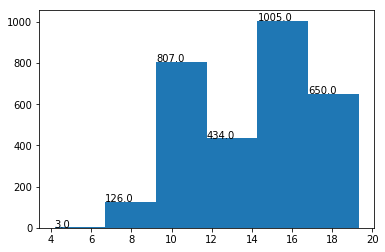

In [194]:
bin_size = 6
bins = plt.hist(np.log(df['Opening Weekend USA']), bin_size)
for i in range(bin_size):
    plt.text(bins[1][i],bins[0][i],str(bins[0][i]))

print ("The bins are:")
for i in  range(bin_size):
    print ("label", i , ":",  math.exp(bins[1][i]), '-' ,math.exp(bins[1][i+1]), "," , str(bins[0][i]) , "movies")

#print (df[df['Opening Weekend USA'] == np.max(df['Opening Weekend USA'] )]['Title'])

In [219]:
def get_log_label (bins, box_office_value):
    log_val = np.log(box_office_value)
    for i in range(len(bins[1])):
        if bins[1][i] <= log_val and log_val <= bins[1][i+1]:
            return i
    return len(bins[1]) - 1


def get_labels(gross):
    gross_classes = np.array([0, 0.005, 0.01, 0.02, float('Inf')]) * 1e8
    
    labels = []
    for i in gross:
        for j in range(len(gross_classes)):
            if gross_classes[j] <= i < gross_classes[j+1]:
                labels.append(j)
    return labels


In [220]:
def one_hot_encoding_column(df, col_name):
    item_map = {}
    item_count = 0
    total_columns = len(df)
    for i in range(total_columns):
        items = str(df[col_name].iloc[i])
        items_arr = items.split(",")
        for item in items_arr:
            item = item.strip()
            if item not in item_map:
                item_map[item] = item_count
                item_count += 1
    
    Matrix = [[0 for x in range(item_count)] for y in range(total_columns)] 
    for i in range(total_columns):
        items = str(df[col_name].iloc[i])
        items_arr = items.split(",")
        for item in items_arr:
            item = item.strip()
            idx = item_map[item]
    return item_map, np.asarray(Matrix)
    
actors_map, actors_Matrix = one_hot_encoding_column(df, 'Actors')
genre_map, genre_Matrix = one_hot_encoding_column(df, 'Genre')
contry_map, country_Matrix = one_hot_encoding_column(df, 'Country')
production_map, production_Matrix = one_hot_encoding_column(df, 'Production')
rated_map, rated_Matrix = one_hot_encoding_column(df,'Rated')
year_map, year_Matrix = one_hot_encoding_column(df,'Year')
director_map, director_Matrix = one_hot_encoding_column(df, 'Director')
released_map, released_Matrix =  one_hot_encoding_column(df, 'Released')


In [227]:
from sklearn.linear_model import LogisticRegression


movie_size = (len(df))
test_size = int(movie_size/5)
sample_size = movie_size - test_size

#labels = [get_log_label(bins, o) for o in df['Opening Weekend USA']]
labels2 = get_labels(df['Opening Weekend USA'])
t_Matrix = genre_Matrix

x_train = t_Matrix[:sample_size]
x_test = t_Matrix[sample_size: ]

y_train = np.array(labels2[:sample_size])
y_test = np.array(labels2[sample_size: ])

clf_l2_LR = LogisticRegression(multi_class="multinomial", solver = 'lbfgs')

clf_l2_LR.fit(x_train, y_train)
y_predit = clf_l2_LR.predict(x_test)

#for ii in range (len(y_test)):
    #print (y_predit[ii], y_test[ii])


print (np.mean(y_predit == y_test))

0.5305785123966942


In [188]:
def split_actors(index, arr):
    try:
        return arr.split(',')[index].strip()
    except IndexError:
        return 'Unknown'
        
df['Actor0'] = [split_actors(0, a) for a in df['Actors']]
df['Actor1'] = [split_actors(1, a) for a in df['Actors']]
df['Actor2'] = [split_actors(2, a) for a in df['Actors']]
df['Actor3'] = [split_actors(3, a) for a in df['Actors']]

In [151]:
df['Oscar'] = [int(str.find('Oscar') > 0) for str in df['Awards']]
df['Wins'] = [int(str.find('win') > 0) for str in df['Awards']]

print (len(df[df['Wins'] == 1]))

2309


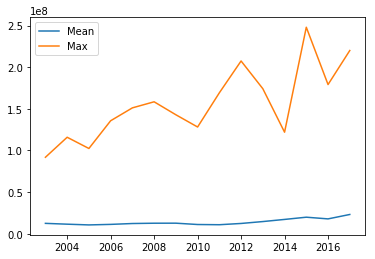

In [142]:
years = [i for i in range (2003, 2018)]
years_count = len(years)
avg_opening_by_year_mean = [np.mean(df[df['Year']== i]['Opening Weekend USA']) for i in years]
avg_opening_by_year_max = [np.max(df[df['Year']== i]['Opening Weekend USA'] ) for i in years]

plt.plot(years, avg_opening_by_year_mean, label='Mean')
plt.plot(years, avg_opening_by_year_max, label = 'Max')
plt.legend()
plt.show()


162911.61463928752